# A MNIST classification project
MNIST is a popular dataset containing many handwritten digits. The goal is to teach a model to recognize the digits. This notebook follows the book Hands-On Machine Learning chapter 3.

## Setup
Firstly, let us import useful libraries and configure matplotlib for visualization.

In [4]:
import sys
import sklearn
import numpy as np
import os

IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
# change runtime configuration defaults
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# where to save the figures from the dataset
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## MNIST
Let's import the dataset from sklearn.

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

C:\Users\juziu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

There are 70,000 positions in this dataset and each image jas 784 features (2 dimentional dataset). These pictures are in grayscale, thus the 784 means basically 28x28 resolution where each pixel is represented with value from 0 to 255. we can see an individual image by reshaping it to 28x28 and plot it.

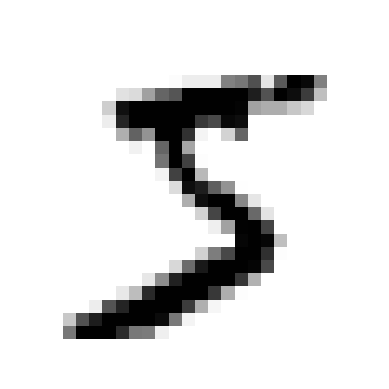

In [8]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off") # turns off axis labels
plt.show()

In [9]:
y[0]

'5'

We can see that the image looks like 5, and indeed the label confirms that. Label is string so let's change it to numbers.

In [10]:
y = y.astype(np.uint8)

As this set is already prepared for training and splitting (first 60,000 are for training and last 10,000 are for testing) let's just divide this dataset.

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Binary classifier
We can now start slowly and train a model to detect only one digit e.g. only 3. Let's try *Stochastic Gradient Decent* (SGD).

In [24]:
y_train_3 = (y_train == 3)
y_test_3 = (y_test == 3)
y_train_3[:11]

array([False, False, False, False, False, False, False,  True, False,
       False,  True])

In [15]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_3)

SGDClassifier(random_state=42)

In [17]:
sgd_clf.predict([some_digit]) # this is the first of the dataset which is 5

array([False])

In [27]:
print(sgd_clf.predict([X[7]]), sgd_clf.predict([X[10]]))
print(y[7], y[10])

[False] [ True]
3 3


Looks like here the model classifies some right, some wrong. Let's evaluate

## Measuring performance
This is not as easy task as regression, so we have to learn new concepts.

### Cross Validation
We can implement our own cross validation using StratifiedKFold from sklearn

In [38]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_3):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    X_test_fold = X_train[test_index]
    y_train_folds = y_train_3[train_index]
    y_test_fold = y_train_3[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_corr = sum(y_pred==y_test_fold)
    print(n_corr / len(y_pred))

0.9505
0.9649
0.9687


Let's use built-in function for cross-validation.

In [40]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_3, cv=3, scoring="accuracy")

array([0.9496 , 0.9624 , 0.96275])

Due to the slight randomness the scores vary slightly, though the overall score is above 94%. Well let's just make a classifier that always tells "not a 3", i.e. always 0.

In [45]:
from sklearn.base import BaseEstimator
class Never3Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [46]:
never_3_clf = Never3Classifier()
cross_val_score(never_3_clf, X_train, y_train_3, cv=3, scoring="accuracy")

array([0.8962 , 0.89975, 0.8975 ])

The accuracy is still substancially high, about 90%. That's because there are about 10% of images of 3s.  
Thus, accuracy is generally not desired in classification tasks.

### Confusion Matrix
A better way to evaluate performance is to look at the *confusion matrix*. The idea is to count the number of times classifier confused for example 3 with 6. The matrix creates this for every confused instance (every other than 3 number).

In [48]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3)

The *cross_val_predict* function performs the cross-validation, but it returns predictions that were made on each test fold.

In [50]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_3, y_train_pred)

array([[53477,   392],
       [ 2113,  4018]], dtype=int64)

Now the rows represent each **actual** class (in this case 1st row is *True* and 2nd is *False*).  
The columns however represent **predicted** class (in this case 1st column is *True* and 2nd is *False*).

In this matrix, the first row represents other numbers than 3 (**negative** class), and second - the number 3 (**positive** class).  
In the negative class the wrong predictions we consider *false negative*,  
in the positive class, *false positive*.

### Precision and recall
We may consider a different metric (concise), that is a single number. Precision and Recall are both ratios, depending on what we want to measure.  
If the number of precisely caught positives, than **precision** is the right choice.
The ratio of caught positives and all instances of this class is showed by **recall**.  
Combining both is used in F1 score (harmonic mean).

In [51]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_3, y_train_pred))
print(recall_score(y_train_3, y_train_pred))

0.9111111111111111
0.655358016636764


This is definitely not the best score, though it seems like the 3-detector has not the best idea of how 3 looks like, but if it knows, it has a high chance it identified a 3 properly. It identifies 3s 65.5% of times and the correctness is at the level of 91%.  
We can now combine them and see the F1 score.

In [53]:
from sklearn.metrics import f1_score
f1_score(y_train_3, y_train_pred)

0.7623565126648326

The f1 score is definitely not the most precise metric, but it gives an overall idea. The precision and recall importance vary depending on a situation, where you can accept more false positives, but catch every possible instance, or in a situation where you can pass many good ones, though you need the highest confidence of correctness.  
Unfortunately you can't have both good parameters if other methods are not effective, you need to make a tradeof more often than not.

### Precision/Recall Tradeoff
In scikit-learn we can call decision_function() that returns a score for each instance and makes predictions using a threshold you want.

In [59]:
y_scores = sgd_clf.decision_function([X[10]])
y_scores

array([1378.05599034])

In [61]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

SGDClassifier by default uses a threshold 0 and we can either raise or lower it.

In [62]:
threshold = 2000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Raising threshold decreases recall and lowers precision and vice versa.  
How to decide what threshold to set? There is a way to compute precision and recall for all possible thresholds using precision_recall_curve()

Firstly, compute all scores for the dataset.

In [64]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3,
method="decision_function")

Then, call the function.

In [65]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_3, y_scores)

Now, plot the results.

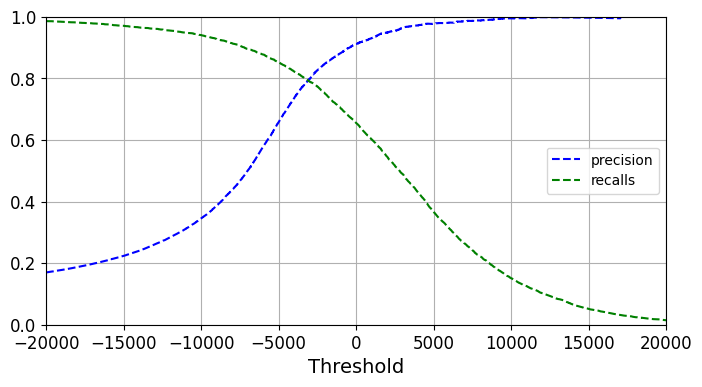

In [73]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="recalls")
    plt.xlabel("Threshold")
    plt.legend(loc="center right")
    plt.grid(True)
    plt.axis([-20000, 20000, 0, 1])
    
plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

To see the precision/recall tradeoff we can plot them directly to each other.

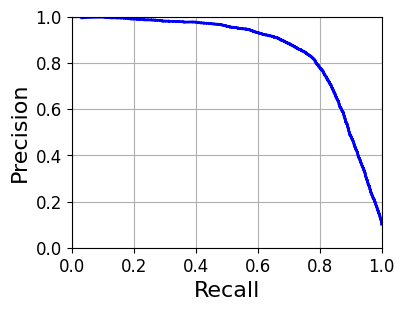

In [75]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(4, 3))

plot_precision_vs_recall(precisions, recalls)
plt.show()

We can decide we want 75% precision, but to be precise we can search for the lowest threshold that can give us this result. (np.argmax() - gives first index of the maximum value)

In [78]:
threshold_75_precision = thresholds[np.argmax(precisions >= 0.75)]
threshold_75_precision

-3787.7891191451854

Now to make predictions we use predict() method.

In [79]:
y_train_pred_75 = (y_scores >= threshold_75_precision)
print(precision_score(y_train_3, y_train_pred_75))
print(recall_score(y_train_3, y_train_pred_75))

0.7500375093773444
0.8153645408579351


### The ROC curve
#### Receiver operating characteristic
is a common tool used with binary classifiers. ROC plots *true positive rate* (recall) against *false positive rate*.

In [81]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_3, y_scores)

Let's plot the ROC.

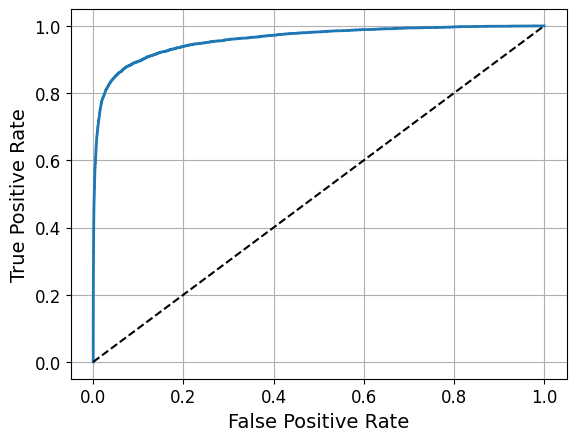

In [85]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.grid(True)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.plot([0, 1], [0, 1], 'k--')
    
plot_roc_curve(fpr, tpr)
plt.show()

One way to understand this graph is to interpret the dotted line as a random classifier (FPR/TPR=1 thus doesn't make a difference).  
The best ratio is to maximize the distance from this line when on the function, thus the point around (0.05, 0.9) is the best parameter for this classifier.

Another way to compare classifiers is to measure AUC (*area under the curve*). The best classifier has AUC=1 and random AUC=0.5 .

In [87]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_3, y_scores)

0.9599243001892759

Here it seems like the classifier is very good by this metric, but as we have established earlier, that is because the positives are much sparser than negatives. It's better to use PR curve.

Let's train Random Forest Classifier, and compare it to the current model.

In [89]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_3, cv=3, method="predict_proba")

In [90]:
y_probas_forest

array([[0.62, 0.38],
       [1.  , 0.  ],
       [0.94, 0.06],
       ...,
       [0.96, 0.04],
       [1.  , 0.  ],
       [0.98, 0.02]])

Now we need to change probabilities into scores. We can do that by considering score as the probability from the positive class (2nd place in each array).

In [92]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_3,y_scores_forest)

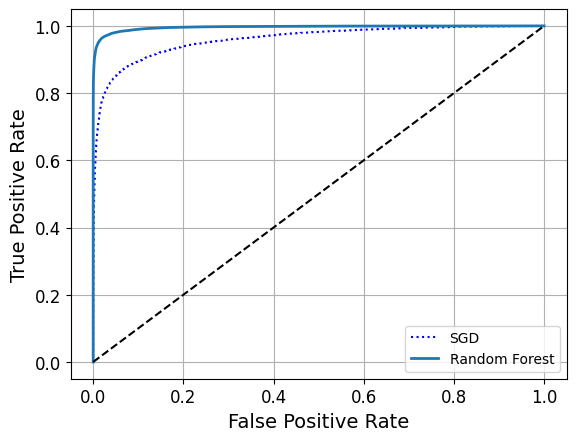

In [93]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

It is clear that the Random Forrest's ROC curve looks better than SGD Classifier's. Therefore the AUC must be better too.

In [95]:
roc_auc_score(y_train_3, y_scores_forest)

0.995864544068936

In [97]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_3, cv=3)
print(precision_score(y_train_3, y_train_pred_forest))
print(recall_score(y_train_3, y_train_pred_forest))

0.9947481034818129
0.8341216767248409


In [98]:
f1_score(y_train_3, y_train_pred_forest)

0.9073811213626686

This time, the evaluation is much better. Seems like Random Forest is definitely well thought choice.

## Multiclass Classification
Now we can focus on classifying every number. We can take OvA or OvO strategy. Let's try using SGDClassifier

In [99]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [112]:
print([y[:10]])
pred = []
for i in range(10):
    pred.append(sgd_clf.predict([X[i]])[0])
pred

[array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)]


[3, 0, 4, 1, 9, 2, 1, 3, 1, 4]

You can see, that the evaluation is not perfect (first digit is wrong), though overall looks very reasonably promising.  
This model is trained by evaluating all digits, not only seeing if this is the number 3.  
Actually sklearn trained 10 hidden classifiers, that later determine what is the correct number based on the highest score.

In [113]:
some_digit = X[0]
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [114]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

We can see in this case what scores are associated with what number. This was a wrong prediction, but the second best was the correct answer.

If we wanted, we could easily try the OvO Classifier based on SGDClassifier. This would take substential amount of time.  
Training a RandomForestClassifier is much easier.

In [115]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

This time it seems like the number is correctly assigned.

In [116]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

The model clearly thinks with 90% probability that the number is 5, which is correct.

Let's use cross validation for evaluation of our models.

In [117]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

The score is over 85% on every test fold, so it's pretty good. If the classification was random, it should be around the level of 10% (1 in 10 chance you guess the correct digit).

To increase the results we can use scaler (the number is going to be fit in range from 0 to 1), thus slightly improving efficiency of the model.

In [120]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

It's clear that this simple transformation made a model perform with at least 89.8% accuracy.

## Error Analysis
Here for the purpuse of the learning I will skip the hyperparameter tuning and go straight to the confussion matrix.

In [122]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

In [123]:
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

This representation is not that clear if you don't know what to look for, thus let's make a graphic representation.

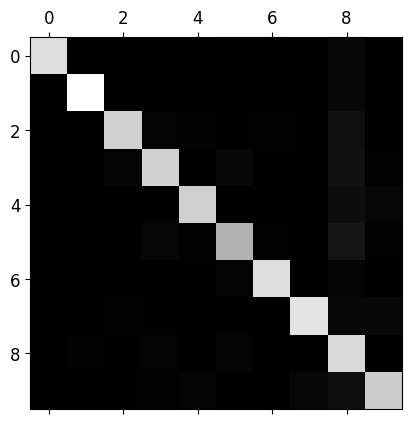

In [124]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

The more light on diagonal the better. This is fairly good, but you can see the darker shades, like in digit 5. You can argue that the model has worse performance on this number, than the rest.

Let's compare the errors. We need to divide each value by the total number of photos of each digit.

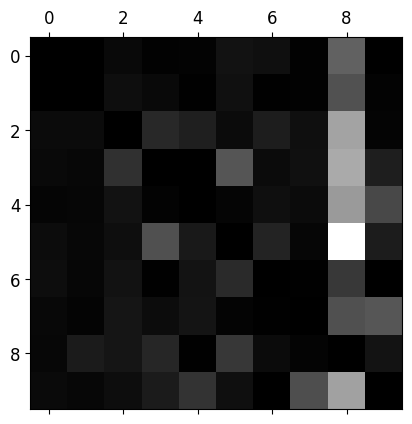

In [129]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums # relative error

np.fill_diagonal(norm_conf_mx, 0) # keep the errors only
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

The column for 8 is disproportionately brighter than other columns, however the row for 8 is not as distinctive.  
This means that many numbers get misinterpreted as 8.  
  
Another example is 5 and 3 and vice versa get confused.  
Outshone by the 8, but many numbers are also often confused with 9.

To correct these errors, you could gather more data, e.g. more numbers that look like 8 but aren't. Another way would be to involve computer vision algorithms for preprocessing and then it would recognize more patterns and point out on more significant pars of the image (like loops or legs)

Below there is a copied function from the book that allows you to plot multiple images.

In [130]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

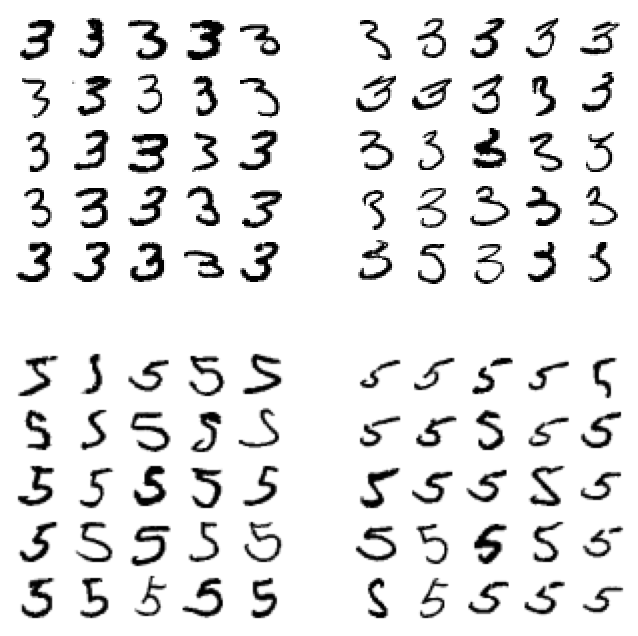

In [131]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

Left column shows numbers identified as 3, and column on the right numbers as 5.  
Some digits are poorly written, however we can recognize many without a problem.  
The problem lies in the model used - SGDClassifier is a linear model. It basically assigns a weight per pixel and sums it up. Since 3 and 5 have similar amount of pixels used, this model gets easily confused.  
Preprocessing - transformation and different formation of these numbers can greatly improve the model's performance.

## Multilabel classification
When we want to recognize many binary classes (like faces of few people - Alex, Bob, Chris) from one instance (picture and many faces and see if they are there - 1,0,1).

In book there was example of classifying a number if it's large, and/or odd. This classifier may take a very long amount of time, that's why I'm not including it here.

## Multioutput classification
This is the classification that can output multiple results. For example, you could build image denoiser, and it will output an array.

## K Neighbors Classifier
Let's now try KNeighborsClassifier that should work well in this case.

In [141]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(weights='distance')
knn_clf.fit(X_train_scaled, y_train)

KNeighborsClassifier(weights='distance')

In [143]:
y_knn_train_pred = cross_val_predict(knn_clf, X_train_scaled, y_train, cv=3)

In [146]:
print(precision_score(y_train, y_knn_train_pred, average=None))
print(recall_score(y_train, y_knn_train_pred, average=None))

[0.95944609 0.95173497 0.95949235 0.92958199 0.94913173 0.9277086
 0.95361166 0.93378959 0.96201365 0.89600652]
[0.98261016 0.98857906 0.92631756 0.94307617 0.9262239  0.92086331
 0.97262589 0.93647247 0.89164245 0.92402084]


Above we can see score for each class (each number).

In [147]:
f1_score(y_train, y_knn_train_pred, average='weighted')

0.941970626373265

As we can see, the weighted average of all numbers in f1 score is quite high at the level of 94%.

We can shift now every image in every direction thus artificially enlarging the dataset. It is called *data augmentation*.

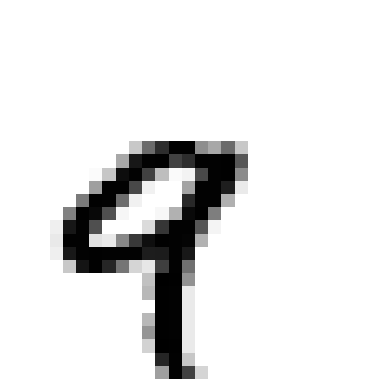

In [151]:
from scipy.ndimage import shift

def shift_photo(photo_arr, dx, dy):
    return shift(photo_arr.reshape(28, 28), [dx, dy]).reshape(784)

plot_digit(shift_photo(X[4], 3, -3))

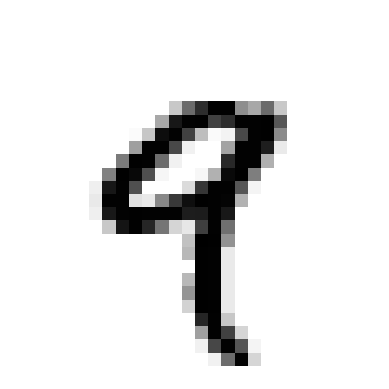

In [150]:
plot_digit(X[4])

We can see that the first image is shifted in an expected way. Now let's do that for every digit in dataset 4 times (every direction) and add them to the set.

In [152]:
X_train_augmented = [X_train]
y_train_augmented = [y_train]

for dx, dy in ((-1, 0), (0, 1), (1, 0), (0, -1)):
    shift_images = np.apply_along_axis(shift_photo, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_augmented.append(shift_images)
    y_train_augmented.append(y_train)

X_train_augmented = np.concatenate(X_train_augmented)
y_train_augmented = np.concatenate(y_train_augmented)
X_train_augmented.shape, y_train_augmented.shape

((300000, 784), (300000,))

Now let's train KNN Classifier on new expanded dataset.

In [154]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(weights='distance')

In [155]:
y_knn_augmented_pred = knn_clf.predict(X_test)

In [157]:
f1_score(y_test, y_knn_augmented_pred, average='weighted')

0.9765862006382445

Accuracy is now better - raising from ~94.2% to ~97.66%.  
Let's see if we can tune hyperparameters to bump the score with augmented dataset.

**Warning:** the following cell ran about 2hrs on my computer, depending on your hardware it may take longer or shorter.

In [162]:
from sklearn.model_selection import GridSearchCV
param_grid = [{"weights": ['uniform', 'distance'], 'n_neighbors': [2, 3, 4, 5]}]
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=1)
grid_search.fit(X_train_augmented, y_train_augmented)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ....n_neighbors=2, weights=uniform;, score=0.991 total time= 3.0min
[CV 2/5] END ....n_neighbors=2, weights=uniform;, score=0.958 total time= 2.9min
[CV 3/5] END ....n_neighbors=2, weights=uniform;, score=0.958 total time= 2.9min
[CV 4/5] END ....n_neighbors=2, weights=uniform;, score=0.971 total time= 3.0min
[CV 5/5] END ....n_neighbors=2, weights=uniform;, score=0.947 total time= 3.0min
[CV 1/5] END ...n_neighbors=2, weights=distance;, score=0.992 total time= 2.9min
[CV 2/5] END ...n_neighbors=2, weights=distance;, score=0.979 total time= 2.9min
[CV 3/5] END ...n_neighbors=2, weights=distance;, score=0.969 total time= 2.9min
[CV 4/5] END ...n_neighbors=2, weights=distance;, score=0.982 total time= 2.9min
[CV 5/5] END ...n_neighbors=2, weights=distance;, score=0.968 total time= 2.9min
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.995 total time= 2.9min
[CV 2/5] END ....n_neighbors=3, weights=uniform;,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=1,
             param_grid=[{'n_neighbors': [2, 3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [163]:
grid_search.best_score_

0.9778600000000001

In [164]:
grid_search.best_params_

{'n_neighbors': 2, 'weights': 'distance'}

In [166]:
y_pred_fin = grid_search.predict(X_test)
f1_score(y_test, y_pred_fin, average='weighted')

0.9726738979028862

Seems like the performance on the new data is about 97.3%, which is slightly worse than previous example without tuning.  
Of course this may vary, however the winner seems to be KNeighbotsClassifier with default values, but gaining more insight could provide some improvements.